In [1]:
"""""""""""""""""""""""""""""""""""""""""""PLOT_UTILS"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

'PLOT_UTILS'

In [1]:
from itertools import product
from line_profiler import LineProfiler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import numba
from arviz.data import load_arviz_data

In [3]:
def make_2d(ary):
    dim_0, *_ = np.atleast_1d(ary).shape
    print(dim_0, *_)
    return ary.reshape(dim_0, -1, order="F")

In [4]:
make_2d(np.random.randn(100,100, 100))

100 100 100


array([[ 0.54274803, -0.20330926,  0.8220762 , ...,  0.46404236,
        -1.05728914,  0.02055792],
       [ 0.27257693,  0.40323913, -2.01143283, ...,  0.12063357,
         1.04820896,  0.36745557],
       [ 0.80804887, -0.7996404 , -0.88809632, ...,  0.98012719,
         1.23568269, -0.36362257],
       ...,
       [-0.32542601, -2.49209461, -0.5097057 , ..., -0.01428286,
        -0.22656544,  0.61643566],
       [ 0.76143337, -1.12513657, -1.23516957, ..., -1.24504894,
         0.86450795,  1.02210676],
       [ 0.84701226,  0.65407616, -0.73354398, ..., -0.51274676,
         1.97933944, -0.58934219]])

In [5]:
lp = LineProfiler()
wrapper = lp(make_2d)
wrapper(np.random.randn(100,100, 100))
lp.print_stats()

100 100 100
Timer unit: 1e-06 s

Total time: 0.01203 s
File: <ipython-input-3-f14325e79911>
Function: make_2d at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def make_2d(ary):
     2         1         38.0     38.0      0.3      dim_0, *_ = np.atleast_1d(ary).shape
     3         1        870.0    870.0      7.2      print(dim_0, *_)
     4         1      11122.0  11122.0     92.5      return ary.reshape(dim_0, -1, order="F")



In [6]:
#nopython numba is compatible only with reshape(one_parameter)

In [7]:
def selection_to_string(selection):
    return ", ".join(["{}".format(v) for _, v in selection.items()])


In [8]:
dict = {"key:1":"oo", "key_2":"000"}
selection_to_string(dict)

'oo, 000'

In [9]:

def _scale_fig_size(figsize, textsize, rows=1, cols=1):
    params = mpl.rcParams
    rc_width, rc_height = tuple(params["figure.figsize"])
    rc_ax_labelsize = params["axes.labelsize"]
    rc_titlesize = params["axes.titlesize"]
    rc_xt_labelsize = params["xtick.labelsize"]
    rc_linewidth = params["lines.linewidth"]
    rc_markersize = params["lines.markersize"]
    if isinstance(rc_ax_labelsize, str):
        rc_ax_labelsize = 15
    if isinstance(rc_titlesize, str):
        rc_titlesize = 16
    if isinstance(rc_xt_labelsize, str):
        rc_xt_labelsize = 14

    if figsize is None:
        width, height = rc_width, rc_height
        sff = 1 if (rows == cols == 1) else 1.15
        width = width * cols * sff
        height = height * rows * sff
    else:
        width, height = figsize

    if textsize is not None:
        scale_factor = textsize / rc_xt_labelsize
    elif rows == cols == 1:
        scale_factor = ((width * height) / (rc_width * rc_height)) ** 0.5
    else:
        scale_factor = 1

    ax_labelsize = rc_ax_labelsize * scale_factor
    titlesize = rc_titlesize * scale_factor
    xt_labelsize = rc_xt_labelsize * scale_factor
    linewidth = rc_linewidth * scale_factor
    markersize = rc_markersize * scale_factor

    return (width, height), ax_labelsize, titlesize, xt_labelsize, linewidth, markersize



In [10]:
lp = LineProfiler()
wrapper = lp(_scale_fig_size)
wrapper(None, None)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 0.000154 s
File: <ipython-input-9-d486bf7299a1>
Function: _scale_fig_size at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def _scale_fig_size(figsize, textsize, rows=1, cols=1):
     3         1          7.0      7.0      4.5      params = mpl.rcParams
     4         1         27.0     27.0     17.5      rc_width, rc_height = tuple(params["figure.figsize"])
     5         1         12.0     12.0      7.8      rc_ax_labelsize = params["axes.labelsize"]
     6         1         10.0     10.0      6.5      rc_titlesize = params["axes.titlesize"]
     7         1         10.0     10.0      6.5      rc_xt_labelsize = params["xtick.labelsize"]
     8         1         10.0     10.0      6.5      rc_linewidth = params["lines.linewidth"]
     9         1         11.0     11.0      7.1      rc_markersize = params["lines.markersize"]
    10         1          4.0      4.0      2.6      if 

In [11]:
# Nothing to optimize here


In [12]:
def get_bins(values):
    x_min = values.min().astype(int)
    x_max = values.max().astype(int)

    # Sturges histogram bin estimator
    bins_sturges = (x_max - x_min) / (np.log2(values.size) + 1)

    # The Freedman-Diaconis histogram bin estimator.
    iqr = np.subtract(*np.percentile(values, [75, 25]))  # pylint: disable=assignment-from-no-return
    bins_fd = 2 * iqr * values.size ** (-1 / 3)

    width = round(np.max([1, bins_sturges, bins_fd])).astype(int)

    return np.arange(x_min, x_max + width + 1, width)

In [13]:
x = np.random.randn(100)

In [14]:
get_bins(x)

array([-2, -1,  0,  1,  2,  3])

In [15]:
_, bins = np.histogram(x)
bins

array([-2.41057539, -1.92724668, -1.44391797, -0.96058926, -0.47726055,
        0.00606816,  0.48939686,  0.97272557,  1.45605428,  1.93938299,
        2.4227117 ])

In [16]:
def default_grid(n_items, max_cols=4, min_cols=3):  # noqa: D202
    def in_bounds(val):
        return np.clip(val, min_cols, max_cols)

    if n_items <= max_cols:
        return 1, n_items
    ideal = in_bounds(round(n_items ** 0.5))

    for offset in (0, 1, -1, 2, -2):
        cols = in_bounds(ideal + offset)
        rows, extra = divmod(n_items, cols)
        if extra == 0:
            return rows, cols
    return n_items // ideal + 1, ideal

In [17]:
lp = LineProfiler()
wrapper = lp(default_grid)
wrapper(50,10,10)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 9.3e-05 s
File: <ipython-input-16-9c94a7ff0adc>
Function: default_grid at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def default_grid(n_items, max_cols=4, min_cols=3):  # noqa: D202
     2         1          3.0      3.0      3.2      def in_bounds(val):
     3                                                   return np.clip(val, min_cols, max_cols)
     4                                           
     5         1          2.0      2.0      2.2      if n_items <= max_cols:
     6                                                   return 1, n_items
     7         1         61.0     61.0     65.6      ideal = in_bounds(round(n_items ** 0.5))
     8                                           
     9         1          1.0      1.0      1.1      for offset in (0, 1, -1, 2, -2):
    10         1         17.0     17.0     18.3          cols = in_bounds(ideal + offset)
    11         1

In [18]:
def _create_axes_grid(length_plotters, rows, cols, **kwargs):
    kwargs.setdefault("constrained_layout", True)
    fig, ax = plt.subplots(rows, cols, **kwargs)
    ax = np.ravel(ax)
    extra = (rows * cols) - length_plotters
    if extra:
        for i in range(1, extra + 1):
            ax[-i].set_axis_off()
        ax = ax[:-extra]
    return fig, ax


In [ ]:
lp = LineProfiler()
wrapper = lp(_create_axes_grid)
wrapper(5,10,14)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 7.39233 s
File: <ipython-input-18-d0a5bdc5dfb8>
Function: _create_axes_grid at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def _create_axes_grid(length_plotters, rows, cols, **kwargs):
     2         1          3.0      3.0      0.0      kwargs.setdefault("constrained_layout", True)
     3         1    7391081.0 7391081.0    100.0      fig, ax = plt.subplots(rows, cols, **kwargs)
     4         1         25.0     25.0      0.0      ax = np.ravel(ax)
     5         1          2.0      2.0      0.0      extra = (rows * cols) - length_plotters
     6         1          1.0      1.0      0.0      if extra:
     7       136        132.0      1.0      0.0          for i in range(1, extra + 1):
     8       135       1073.0      7.9      0.0              ax[-i].set_axis_off()
     9         1          9.0      9.0      0.0          ax = ax[:-extra]
    10         1          2.0      2.

In [17]:
def xarray_var_iter(data, var_names=None, combined=False, skip_dims=None, reverse_selections=False):
    if skip_dims is None:
        skip_dims = set()

    if combined:
        skip_dims = skip_dims.union({"chain", "draw"})
    else:
        skip_dims.add("draw")

    if var_names is None:
        if isinstance(data, xr.Dataset):
            var_names = list(data.data_vars)
        elif isinstance(data, xr.DataArray):
            var_names = [data.name]
            data = {data.name: data}
    
    
    for var_name in var_names:
        if var_name in data:
            new_dims = [dim for dim in data[var_name].dims if dim not in skip_dims]
            vals = [purge_duplicates(data[var_name][dim].values) for dim in new_dims]
            dims = [{k: v for k, v in zip(new_dims, prod)} for prod in product(*vals)]
            if reverse_selections:
                dims = reversed(dims)

            for selection in dims:
                yield var_name, selection, data[var_name].sel(**selection).values
                
def xarray_var_iter_new(data, var_names=None, combined=False, skip_dims=None, reverse_selections=False):
    if skip_dims is None:
        skip_dims = set()

    if combined:
        skip_dims = skip_dims.union({"chain", "draw"})
    else:
        skip_dims.add("draw")

    if var_names is None:
        if isinstance(data, xr.Dataset):
            var_names = list(data.data_vars)
        elif isinstance(data, xr.DataArray):
            var_names = [data.name]
            data = {data.name: data}
    
    
    for var_name in var_names:
        if var_name in data:
            new_dims = [dim for dim in data[var_name].dims if dim not in skip_dims]
            vals = [purge_duplicates_jit(data[var_name][dim].values) for dim in new_dims]
            dims = [{k: v for k, v in zip(new_dims, prod)} for prod in product(*vals)]
            if reverse_selections:
                dims = reversed(dims)

            for selection in dims:
                yield var_name, selection, data[var_name].sel(**selection).values

In [19]:
school = load_arviz_data("centered_eight")

In [20]:
xarray_var_iter(school)

<generator object xarray_var_iter at 0x7f67ff67dba0>

In [10]:
lp = LineProfiler()
wrapper = lp(xarray_var_iter)
wrapper(school.posterior)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-4-7ffb2be6146f>
Function: xarray_var_iter at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def xarray_var_iter(data, var_names=None, combined=False, skip_dims=None, reverse_selections=False):
     2                                               if skip_dims is None:
     3                                                   skip_dims = set()
     4                                           
     5                                               if combined:
     6                                                   skip_dims = skip_dims.union({"chain", "draw"})
     7                                               else:
     8                                                   skip_dims.add("draw")
     9                                           
    10                                               if var_names is None:
    11                                     

In [71]:
def purge_duplicates(list_in):
    _list = []
    for item in list_in:
        if item not in _list:
            _list.append(item)
    return _list

@numba.njit
def purge_duplicates_jit(list_in):
    _list = []
    for item in list_in:
        if item not in _list:
            _list.append(item)
    return _list

In [7]:
%timeit purge_duplicates(np.random.randn(10))

9.45 µs ± 885 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
%timeit purge_duplicates_jit(np.random.randn(10))

3.7 µs ± 87.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
def _create_axes_grid(length_plotters, rows, cols, **kwargs):
    kwargs.setdefault("constrained_layout", True)
    fig, ax = plt.subplots(rows, cols, **kwargs)
    ax = np.ravel(ax)
    extra = (rows * cols) - length_plotters
    if extra:
        for i in range(1, extra + 1):
            ax[-i].set_axis_off()
        ax = ax[:-extra]
    return fig, ax


def _create_axes_grid_jit(length_plotters, rows, cols, **kwargs):
    kwargs.setdefault("constrained_layout", True)
    fig, ax = plt.subplots(rows, cols, **kwargs)
    ax = np.ravel(ax)
    extra = (rows * cols) - length_plotters
    if extra:
        _extra_calc(ax, extra)
    return fig, ax

@numba.jit
def _extra_calc(ax, extra):
    for i in range(1, extra + 1):
        ax[-i].set_axis_off()
    ax = ax[:-extra]
    return ax

399 ms ± 6.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


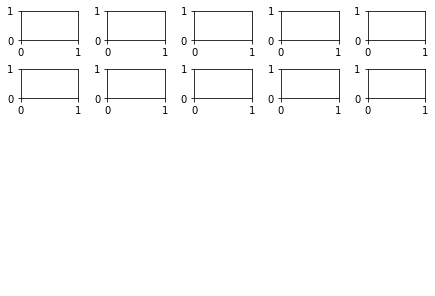

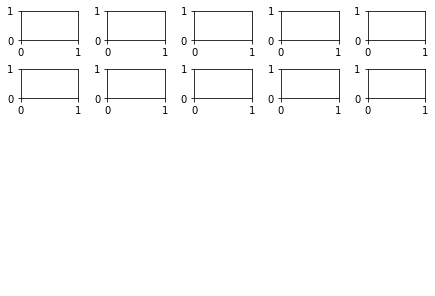

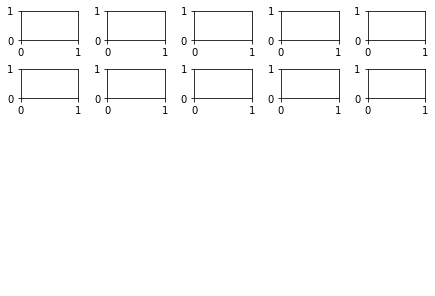

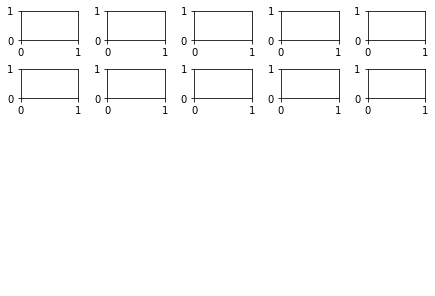

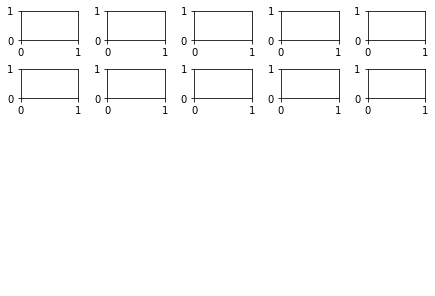

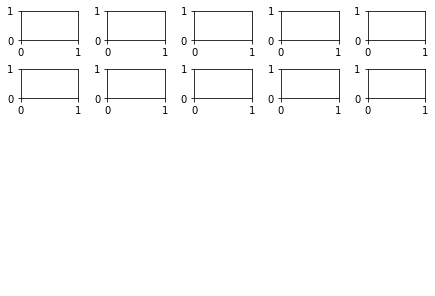

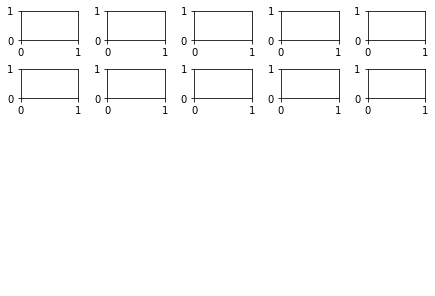

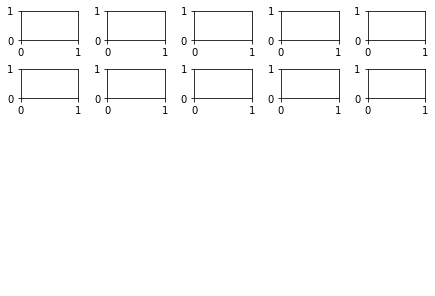

In [11]:
%timeit _create_axes_grid(10, 5,5)

400 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


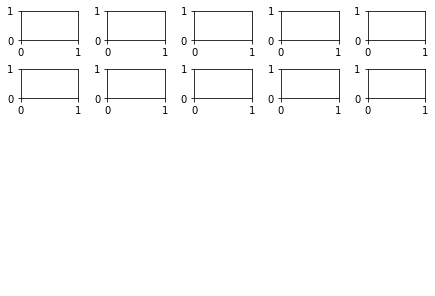

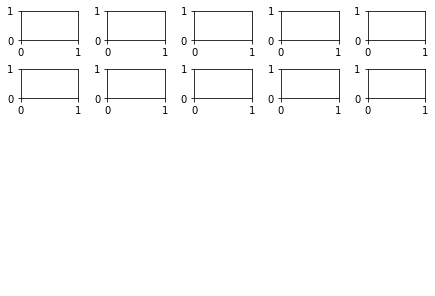

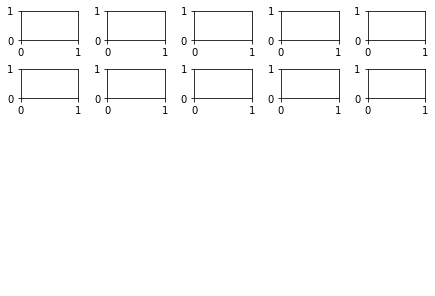

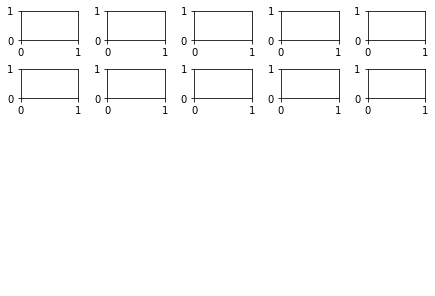

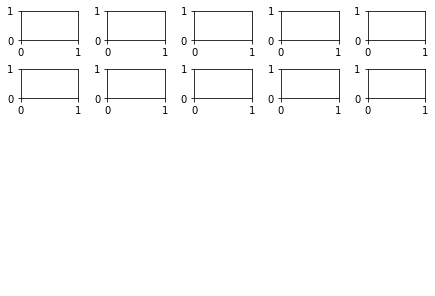

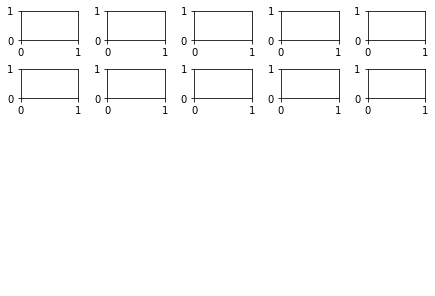

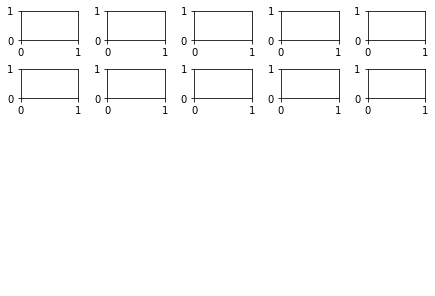

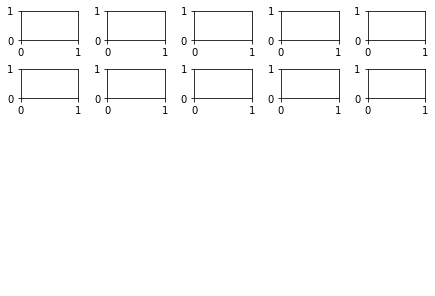

In [14]:
%timeit _create_axes_grid_jit(10,5,5)

In [15]:
#no point jitting the loop


In [80]:


def _var_iter(data, var_names=None, combined=False, skip_dims=None, reverse_selections=False):
    if skip_dims is None:
        skip_dims = set()

    if combined:
        skip_dims = skip_dims.union({"chain", "draw"})
    else:
        skip_dims.add("draw")

    if var_names is None:
        if isinstance(data, xr.Dataset):
            var_names = list(data.data_vars)
        elif isinstance(data, xr.DataArray):
            var_names = [data.name]
            data = {data.name: data}

    for var_name in var_names:
        if var_name in data:
            new_dims = dims(data, var_names, var_name, skip_dims)
            vals = [purge_duplicates_jit(data[var_name][dim].values) for dim in new_dims]
            dimx = zip_dims(data, new_dims, vals)
            if reverse_selections:
                dimx= reversed(dims)

            for selection in dimx:
                yield var_name, selection, data[var_name].sel(**selection).values

@numba.njit
def dims(data, var_names,var_name,skip_dims):
    return [dim for dim in data[var_name].dims if dim not in skip_dims]

@numba.njit
def zip_dims(data, new_dims, vals):
    [{k: v for k, v in zip(new_dims, prod)} for prod in product(*vals)]
    
    


def xarray_var_iter(data, var_names=None, combined=False, skip_dims=None, reverse_selections=False):
    if skip_dims is None:
        skip_dims = set()

    if combined:
        skip_dims = skip_dims.union({"chain", "draw"})
    else:
        skip_dims.add("draw")

    if var_names is None:
        if isinstance(data, xr.Dataset):
            var_names = list(data.data_vars)
        elif isinstance(data, xr.DataArray):
            var_names = [data.name]
            data = {data.name: data}

    for var_name in var_names:
        if var_name in data:
            new_dims = [dim for dim in data[var_name].dims if dim not in skip_dims]
            vals = [purge_duplicates(data[var_name][dim].values) for dim in new_dims]
            dims = [{k: v for k, v in zip(new_dims, prod)} for prod in product(*vals)]
            if reverse_selections:
                dims = reversed(dims)

            for selection in dims:
                yield var_name, selection, data[var_name].sel(**selection).values

In [60]:
%timeit _var_iter(school)

557 ns ± 14.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [62]:
%timeit xarray_var_iter(school)

606 ns ± 17 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [63]:
# X_ARRAY_VAR_ITER

In [68]:
def make_label(var_name, selection, position="below"):
    """Consistent labelling for plots.

    Parameters
    ----------
    var_name : str
       Name of the variable

    selection : dict[Any] -> Any
        Coordinates of the variable
    position : whether to position the coordinates' label "below" (default) or "beside" the name
               of the variable

    Returns
    -------
    label
        A text representation of the label
    """
    if selection:
        sel = selection_to_string(selection)
        if position == "below":
            sep = "\n"
        elif position == "beside":
            sep = " "
    else:
        sep = sel = ""
    return "{}{}{}".format(var_name, sep, sel)

In [69]:
def xarray_to_ndarray(data, *, var_names=None, combined=True):
    unpacked_data, unpacked_var_names, = [], []

    # Merge chains and variables
    for var_name, selection, data_array in xarray_var_iter(
        data, var_names=var_names, combined=combined
    ):
        unpacked_data.append(data_array.flatten())
        unpacked_var_names.append(make_label(var_name, selection))

    return unpacked_var_names, np.array(unpacked_data)

def xarray_to_ndarray_new(data, *, var_names=None, combined=True):
    unpacked_data, unpacked_var_names, = [], []

    # Merge chains and variables
    for var_name, selection, data_array in _var_iter(
        data, var_names=var_names, combined=combined
    ):
        unpacked_data.append(data_array.flatten())
        unpacked_var_names.append(make_label(var_name, selection))

    return unpacked_var_names, np.array(unpacked_data)

In [73]:
def selection_to_string(selection):
    """Convert dictionary of coordinates to a string for labels.

    Parameters
    ----------
    selection : dict[Any] -> Any

    Returns
    -------
    str
        key1: value1, key2: value2, ...
    """
    return ", ".join(["{}".format(v) for _, v in selection.items()])

In [81]:
%timeit xarray_to_ndarray(school.posterior)

17.1 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
